In [40]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

In [114]:
df = pd.read_parquet('./data/final_column제거.parquet')
train = df.copy()
# train = train.reset_index()

In [115]:
to_remove = train.groupby('ENGINEER_REPAIR').filter(lambda x: len(x) <= 10000).index
train = train.drop(to_remove).reset_index()

In [116]:
# del train['KEY_PARTS1']
# del train['KEY_PARTS2']
# del train['KEY_PARTS3']
# del train['KEY_PARTS4']
# del train['KEY_PARTS5']
del train['PARTS_NO1']
del train['PARTS_NO2']
del train['PARTS_NO3']
del train['PARTS_NO4']
del train['PARTS_NO5']
del train['index']
# del train['']

In [117]:
train = train.sample(frac=0.2).reset_index()
del train['index']

In [103]:
train.columns

Index(['MONTH', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG',
       'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'RECEIPT_SYMPTOM',
       'CENTER_CODE', 'PREV_CENTER_CODE', 'PRODUCT_NAME', 'RECLAIM',
       'WARRANTY_TYPE', 'PREV_WARRANTY_TYPE', 'SVC_TYPE', 'PREV_SVC_TYPE',
       'ENGINEER_CODE', 'PREV_ENGINEER_CODE', 'ENGINEER_REPAIR',
       'PREV_ENGINEER_SYMPTOM', 'MULTICLAIM', 'PREV_RECEIPT_SYMPTOM'],
      dtype='object')

In [104]:
train.shape

(2683227, 22)

In [105]:
train['ENGINEER_REPAIR'].nunique()

32

In [106]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.7, .2, .1], size=(train.shape[0],))

train_indices = train[train["Set"]=="train"].index
valid_indices = train[train["Set"]=="valid"].index
test_indices = train[train["Set"]=="test"].index

In [107]:
train.columns[-5]

'ENGINEER_REPAIR'

In [108]:
train_indices

Index([      0,       1,       3,       4,       5,      10,      12,      13,
            14,      15,
       ...
       2683211, 2683213, 2683214, 2683215, 2683217, 2683218, 2683219, 2683222,
       2683223, 2683225],
      dtype='int64', length=1878487)

In [109]:
target = train.columns[-5]
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    print(types[col])
    if types[col] == 'object':
        train[col] = train[col].astype(str)
        print(col, train[col].nunique())
        train[col] = train[col].fillna("VV_likely")
        l_enc = LabelEncoder()
        # train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

object
MONTH 12
float64
object
SUBSIDIARY_NAME 2
object
CAPTIVE_CHANNEL_FLAG 2
object
COMPANY_CODE 5
object
DIVISION_NAME 21
object
MODEL_CODE 14407
object
RECEIPT_SYMPTOM 236
object
CENTER_CODE 2764
object
PREV_CENTER_CODE 1853
object
PRODUCT_NAME 75
int64
object
WARRANTY_TYPE 10
object
PREV_WARRANTY_TYPE 10
object
SVC_TYPE 8
object
PREV_SVC_TYPE 9
object
ENGINEER_CODE 26738
object
PREV_ENGINEER_CODE 17058
object
ENGINEER_REPAIR 32
object
PREV_ENGINEER_SYMPTOM 152
int64
object
PREV_RECEIPT_SYMPTOM 174
object
Set 3


In [85]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [86]:
clf = TabNetClassifier(n_d=16, n_a=16, n_steps=5, gamma=1.5,
                       n_independent=4, n_shared=4,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

/home/js/.conda/envs/LG/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# from pytorch_tabnet.augmentations import ClassificationSMOTE
max_epochs = 100
# aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=100,
    batch_size=128, virtual_batch_size=16,
    num_workers=0,
    weights=1,
    drop_last=False,
    # augmentations=aug
)

In [88]:
from sklearn.metrics import accuracy_score

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_acc}")

BEST VALID SCORE : 0.7377482925082928
FINAL TEST SCORE : 0.7377772149258401


In [93]:
from sklearn.metrics import f1_score

# Macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Macro F1 Score: 0.47630701773279166


In [118]:
train['ENGINEER_REPAIR'] = l_enc.fit_transform(train['ENGINEER_REPAIR'].values)
print(train['ENGINEER_REPAIR'].unique())

[11 17 25  8 18 12 16 31 27  7 21 28 15  9 24 14 10 23 19  6  1 26  2 22
  0 13  4 29  5 30  3 20]


In [119]:
train['ENGINEER_REPAIR'] = l_enc.inverse_transform(train['ENGINEER_REPAIR'].values)
print(train['ENGINEER_REPAIR'].unique())

['DRY SERVICE' 'Installation of new product' 'Parts replaced'
 'Clean set internally' 'Internal adjustment' 'Demo given' 'Gas Charging'
 'Wet/Preventive Maintenance' 'Sealed System Repair' 'Clean Filter'
 'O/W Estimate given' 'Set Found OK' 'External adjustment'
 'Compressor Replaced' 'Part replaced-mechanical (ref#)'
 'Explanation Done' 'Customer education' 'Part replaced-electrical (ref#)'
 'Module/Array/Open Cell Replacement' 'Alignment  mechanical'
 'Adjust by remote' 'Re-Installation'
 'Adjustment  external (give ref#) w/ unit disassembling'
 'Part replaced-appearance (ref#)' 'Accessory Sale' 'Drum Replacement'
 'Adjustment  internal (give ref#)' 'Set Replacement (Customer)'
 'Alignment  eletrical' 'Set Replacement (Dealer)'
 'Adjustment  external (give ref#) w/o unit disassembling'
 'No problem found']


In [42]:
df['PARTS_NO1'].nunique()

70

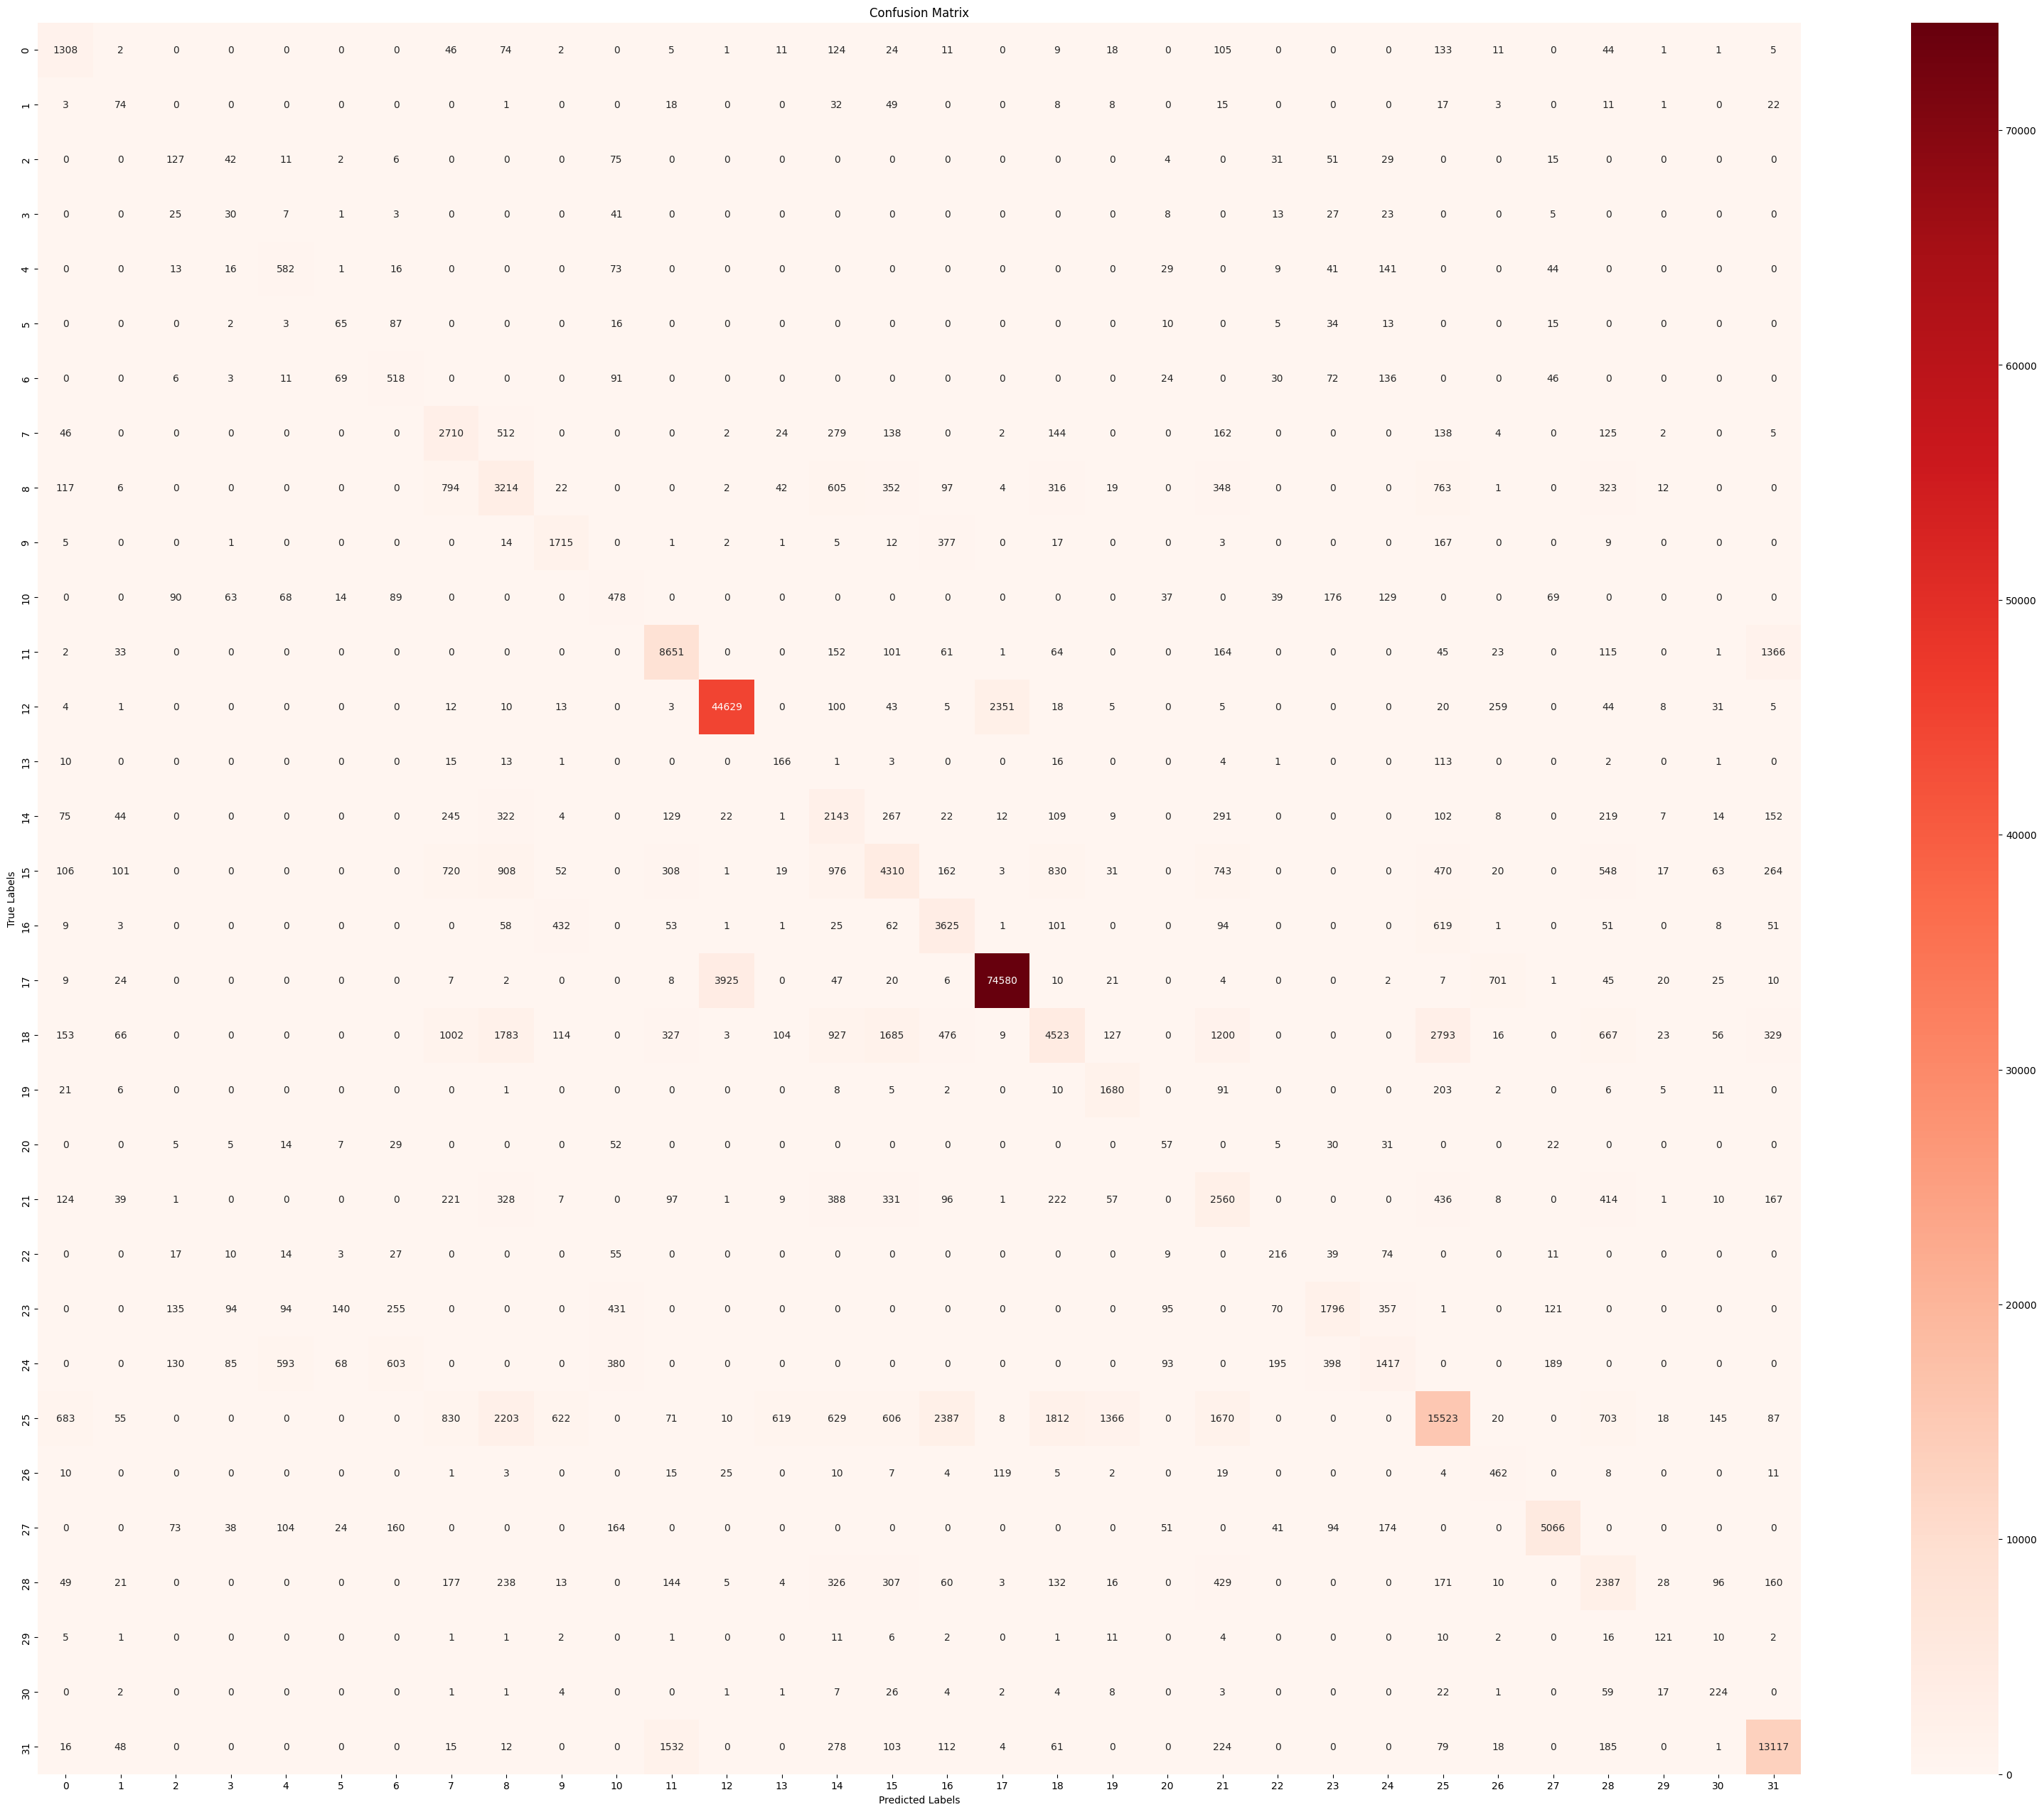

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(40, 32))

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

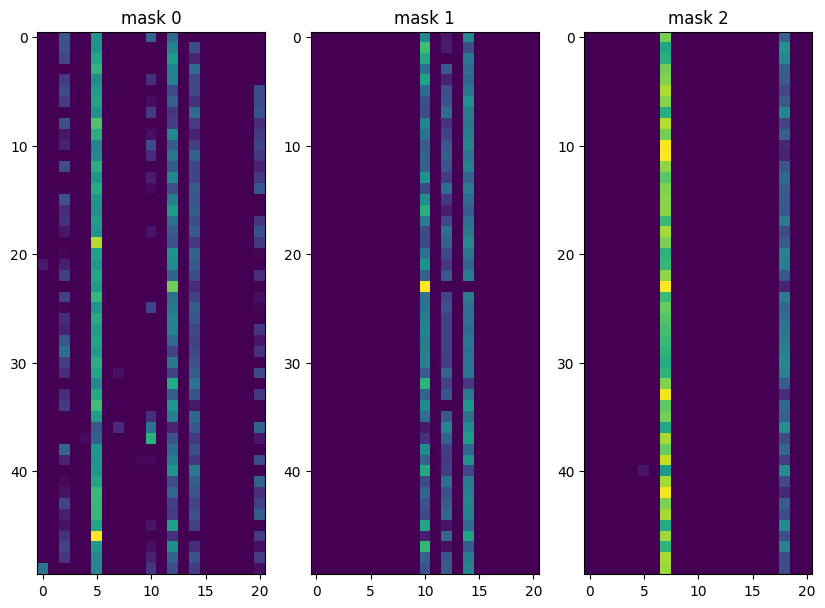

In [90]:
explain_matrix, masks = clf.explain(X_test)
indices = [i for i, x in enumerate(y_pred) if x == 6]
fig, axs = plt.subplots(1, 3, figsize=(10,40))
for i in range(3):
    # random_indices = np.random.choice(masks[i].shape[0], 500, replace=False)
    axs[i].imshow(masks[i][indices[:50]])
    axs[i].set_title(f"mask {i}")

In [120]:
train.columns[7]

'RECEIPT_SYMPTOM'

<Axes: >

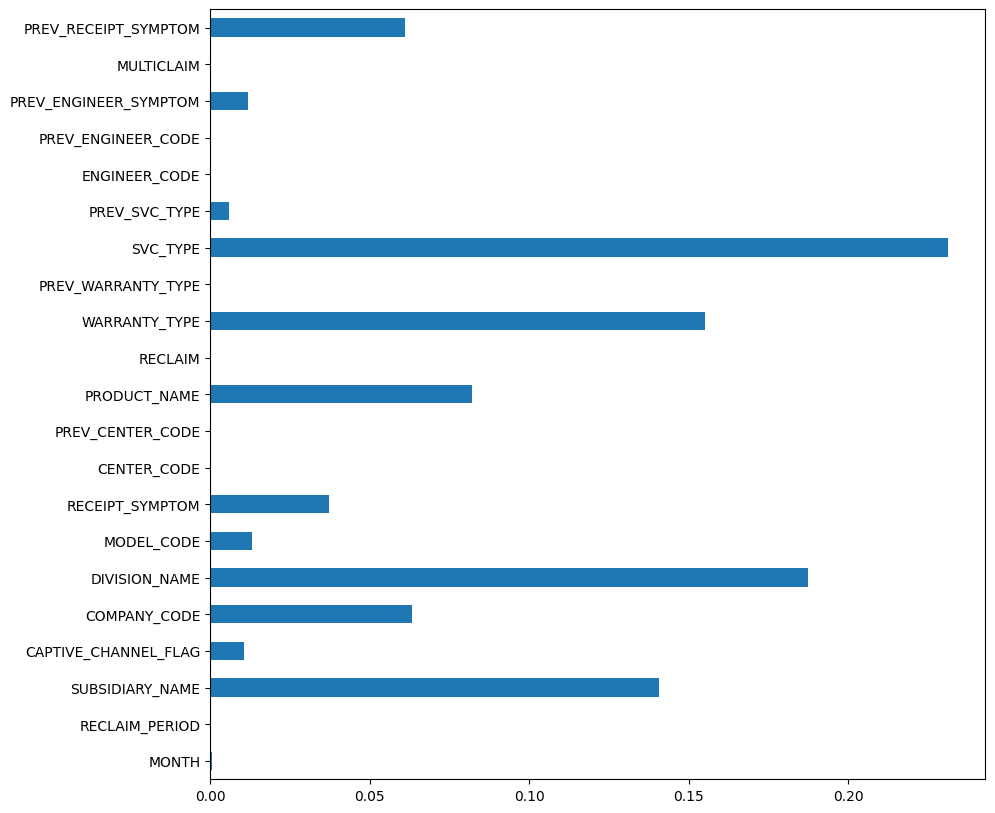

In [92]:
# global
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh', figsize=(10,10))